In [11]:
# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings

filterwarnings("ignore")

# Scikit-learn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split, StratifiedKFold

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Device setup
if not torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

sns.set_style("whitegrid")
print("All imports successful! ✅")

Using device: cpu
All imports successful! ✅


## 1. Load Data and Explore


In [12]:
# Load data
df = pd.read_csv("Analytica.csv")

OCEAN = {
    "EXT": "Extraversion",
    "EST": "Neuroticism",
    "AGR": "Agreeableness",
    "CSN": "Conscientiousness",
    "OPN": "Openness",
}
dimensions = list(OCEAN.keys())

print(f"Dataset shape: {df.shape}")
print(f"\nTotal samples: {len(df)}")
print(f"Labeled samples (non-NaN target): {df['target'].notna().sum()}")
print(f"Unlabeled samples (NaN target): {df['target'].isna().sum()}")
print(f"\nLabeled percentage: {df['target'].notna().mean()*100:.1f}%")

df.head()

Dataset shape: (34163, 112)

Total samples: 34163
Labeled samples (non-NaN target): 5096
Unlabeled samples (NaN target): 29067

Labeled percentage: 14.9%


,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,EXT_time,EST,EST_time,AGR,AGR_time,CSN,CSN_time,OPN,OPN_time,target
0,3.0,2.0,2.0,4.0,4.0,4.0,5.0,3.0,1.0,3.0,...,72.625,0.44,46.155,0.24,82.665,0.10,62.022,0.10,40.415,NaN
1,3.0,4.0,1.0,4.0,3.0,2.0,2.0,4.0,3.0,5.0,...,45.790,0.42,36.420,-0.14,86.422,0.10,56.401,0.26,38.205,0.0
2,3.0,3.0,4.0,4.0,5.0,3.0,3.0,5.0,2.0,2.0,...,64.250,0.42,50.268,0.50,58.487,0.18,44.737,0.34,51.454,NaN
3,1.0,5.0,1.0,5.0,2.0,4.0,1.0,5.0,3.0,5.0,...,50.384,0.64,59.489,0.22,59.080,0.18,66.815,0.32,58.911,NaN
4,1.0,4.0,3.0,5.0,1.0,2.0,2.0,4.0,2.0,4.0,...,59.927,0.46,39.848,0.40,97.554,0.24,45.858,0.42,48.390,0.0


In [13]:
# Check missing values
missing = df.isna().sum()
missing_cols = missing[missing > 0]
print("Columns with missing values:")
print(missing_cols)

Columns with missing values:
target    29067
dtype: int64


In [14]:
# Class distribution in labeled data
df_labeled = df[df["target"].notna()].copy()
df_unlabeled = df[df["target"].isna()].copy()

print("Class distribution in labeled data:")
print(df_labeled["target"].value_counts())
print(f"\nClass 1 percentage: {df_labeled['target'].mean()*100:.2f}%")

Class distribution in labeled data:
target
0.0    2683
1.0    2413
Name: count, dtype: int64

Class 1 percentage: 47.35%


## 2. Preprocessing: Feature Extraction & Scaling


In [15]:
# Extract features (exclude ID and target)
feature_cols = [col for col in df.columns if col not in ["ID", "target"]]
print(f"Number of features: {len(feature_cols)}")

# Prepare data
X_labeled = df_labeled[feature_cols].values
y_labeled = df_labeled["target"].values.astype(int)
X_unlabeled = df_unlabeled[feature_cols].values
unlabeled_ids = df_unlabeled["ID"].values

print(f"X_labeled shape: {X_labeled.shape}")
print(f"X_unlabeled shape: {X_unlabeled.shape}")

Number of features: 110
X_labeled shape: (5096, 110)
X_unlabeled shape: (29067, 110)


In [16]:
# StandardScaler - fit on ALL data (since we use clustering on all)
X_all = np.vstack([X_labeled, X_unlabeled])
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)

X_labeled_scaled = X_all_scaled[: len(X_labeled)]
X_unlabeled_scaled = X_all_scaled[len(X_labeled) :]

print(f"Scaled data - Mean: {X_all_scaled.mean():.4f}, Std: {X_all_scaled.std():.4f}")

Scaled data - Mean: 0.0000, Std: 1.0000


## 3. PCA - Find Optimal Number of Components


In [17]:
# Compute explained variance for all components
pca_full = PCA()
pca_full.fit(X_all_scaled)

cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Find n_components for different thresholds
thresholds = [0.80, 0.85, 0.90, 0.95]
for thresh in thresholds:
    n_comp = np.argmax(cumulative_variance >= thresh) + 1
    print(f"{thresh*100:.0f}% variance explained with {n_comp} components")

80% variance explained with 59 components
85% variance explained with 67 components
90% variance explained with 75 components
95% variance explained with 86 components


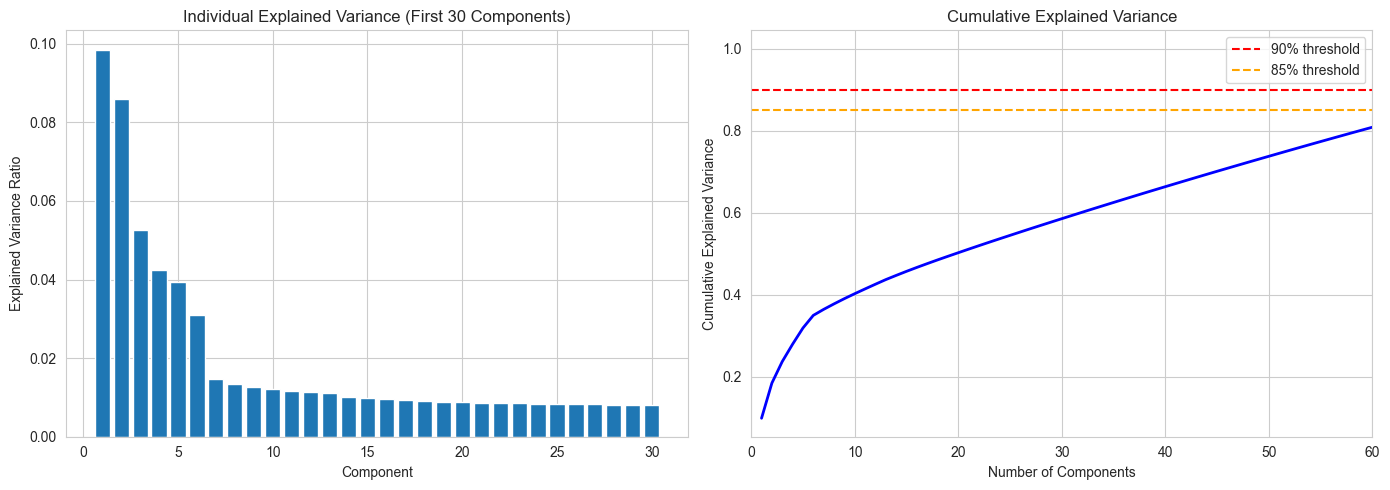

In [18]:
# Plot cumulative explained variance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Individual explained variance
axes[0].bar(range(1, 31), pca_full.explained_variance_ratio_[:30])
axes[0].set_xlabel("Component")
axes[0].set_ylabel("Explained Variance Ratio")
axes[0].set_title("Individual Explained Variance (First 30 Components)")

# Cumulative explained variance
axes[1].plot(
    range(1, len(cumulative_variance) + 1), cumulative_variance, "b-", linewidth=2
)
axes[1].axhline(y=0.90, color="r", linestyle="--", label="90% threshold")
axes[1].axhline(y=0.85, color="orange", linestyle="--", label="85% threshold")
axes[1].set_xlabel("Number of Components")
axes[1].set_ylabel("Cumulative Explained Variance")
axes[1].set_title("Cumulative Explained Variance")
axes[1].legend()
axes[1].set_xlim(0, 60)

plt.tight_layout()
plt.show()

In [19]:
# Apply PCA with optimal components (targeting ~85% variance)
n_components = 35
pca = PCA(n_components=n_components)
X_all_pca = pca.fit_transform(X_all_scaled)

X_labeled_pca = X_all_pca[: len(X_labeled)]
X_unlabeled_pca = X_all_pca[len(X_labeled) :]

print(f"PCA with {n_components} components")
print(f"Explained variance: {sum(pca.explained_variance_ratio_)*100:.2f}%")
print(f"X_labeled_pca shape: {X_labeled_pca.shape}")
print(f"X_unlabeled_pca shape: {X_unlabeled_pca.shape}")

PCA with 35 components
Explained variance: 62.51%
X_labeled_pca shape: (5096, 35)
X_unlabeled_pca shape: (29067, 35)


## 4. KMeans Clustering (Unsupervised Learning)

We apply KMeans on ALL data (labeled + unlabeled) to leverage the full structure of the dataset.


In [20]:
# Find optimal number of clusters using silhouette score
cluster_range = range(2, 16)
silhouette_scores = []
inertias = []

for k in cluster_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_temp = kmeans_temp.fit_predict(X_all_pca)
    score = silhouette_score(X_all_pca, labels_temp)
    silhouette_scores.append(score)
    inertias.append(kmeans_temp.inertia_)
    print(f"k={k}: Silhouette Score = {score:.4f}")

k=2: Silhouette Score = 0.1864
k=3: Silhouette Score = 0.0827
k=3: Silhouette Score = 0.0827
k=4: Silhouette Score = 0.0596
k=4: Silhouette Score = 0.0596
k=5: Silhouette Score = 0.0539
k=5: Silhouette Score = 0.0539
k=6: Silhouette Score = 0.0485
k=6: Silhouette Score = 0.0485
k=7: Silhouette Score = 0.0449
k=7: Silhouette Score = 0.0449
k=8: Silhouette Score = 0.0369
k=8: Silhouette Score = 0.0369
k=9: Silhouette Score = 0.0371
k=9: Silhouette Score = 0.0371
k=10: Silhouette Score = 0.0346
k=10: Silhouette Score = 0.0346
k=11: Silhouette Score = 0.0335
k=11: Silhouette Score = 0.0335
k=12: Silhouette Score = 0.0317
k=12: Silhouette Score = 0.0317
k=13: Silhouette Score = 0.0298
k=13: Silhouette Score = 0.0298
k=14: Silhouette Score = 0.0292
k=14: Silhouette Score = 0.0292
k=15: Silhouette Score = 0.0264
k=15: Silhouette Score = 0.0264


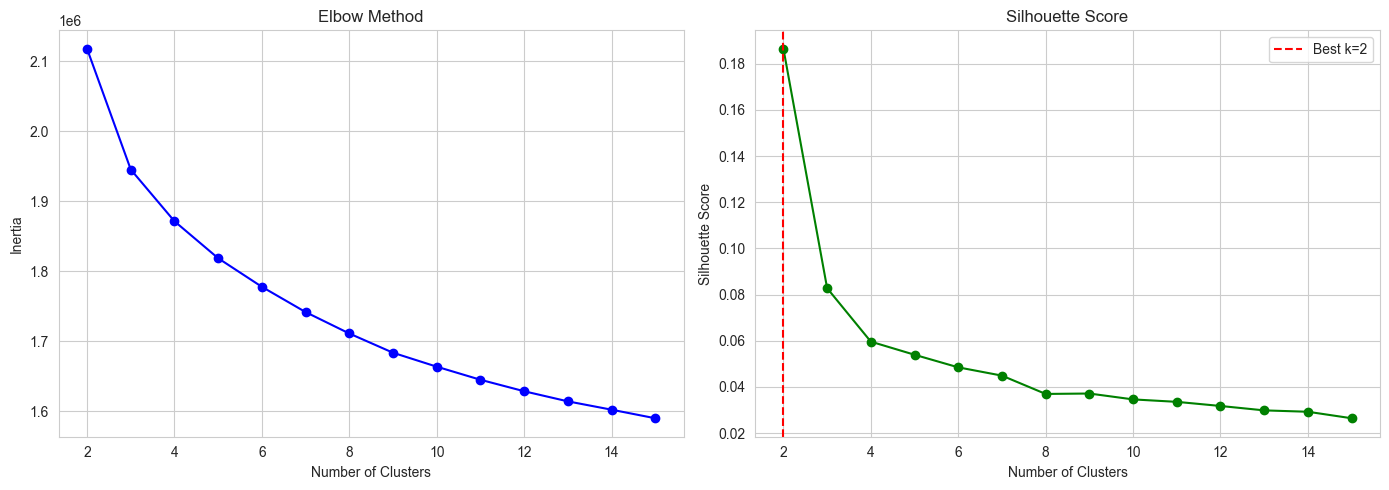


Best number of clusters: 2


In [21]:
# Plot silhouette scores and inertia
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(cluster_range, inertias, "b-o")
axes[0].set_xlabel("Number of Clusters")
axes[0].set_ylabel("Inertia")
axes[0].set_title("Elbow Method")

axes[1].plot(cluster_range, silhouette_scores, "g-o")
axes[1].set_xlabel("Number of Clusters")
axes[1].set_ylabel("Silhouette Score")
axes[1].set_title("Silhouette Score")
best_k = list(cluster_range)[np.argmax(silhouette_scores)]
axes[1].axvline(x=best_k, color="r", linestyle="--", label=f"Best k={best_k}")
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nBest number of clusters: {best_k}")

In [22]:
# Fit KMeans with optimal k
n_clusters = best_k
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
all_cluster_labels = kmeans.fit_predict(X_all_pca)

cluster_labels_labeled = all_cluster_labels[: len(X_labeled)]
cluster_labels_unlabeled = all_cluster_labels[len(X_labeled) :]

print(f"Cluster distribution:")
for i in range(n_clusters):
    count = np.sum(all_cluster_labels == i)
    print(f"  Cluster {i}: {count} samples ({count/len(all_cluster_labels)*100:.1f}%)")

print(f"\nSilhouette Score: {silhouette_score(X_all_pca, all_cluster_labels):.4f}")

Cluster distribution:
  Cluster 0: 8578 samples (25.1%)
  Cluster 1: 25585 samples (74.9%)

Silhouette Score: 0.1864

Silhouette Score: 0.1864


In [23]:
# Analyze target distribution per cluster
cluster_analysis = pd.DataFrame(
    {"cluster": cluster_labels_labeled, "target": y_labeled}
)

cluster_stats = (
    cluster_analysis.groupby("cluster")
    .agg(count=("target", "count"), mean=("target", "mean"), sum=("target", "sum"))
    .reset_index()
)

print("Target distribution per cluster (labeled data only):")
print(cluster_stats)

Target distribution per cluster (labeled data only):
   cluster  count      mean   sum
0        0   1294  0.538640   697
1        1   3802  0.451341  1716


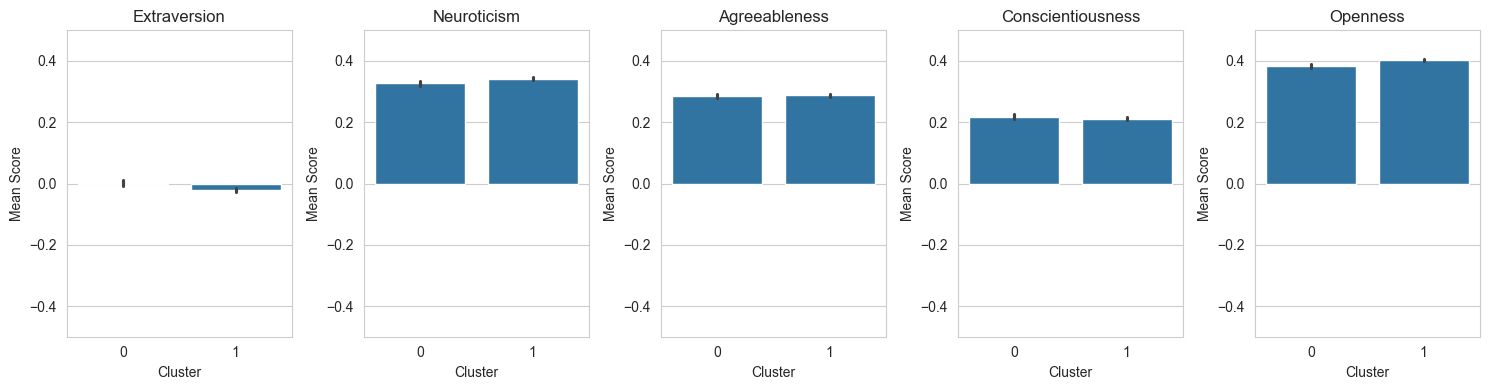

In [24]:
# Visualize cluster analysis with OCEAN scores
cluster_ocean = df_labeled[dimensions + ["target"]].copy()
cluster_ocean["cluster"] = cluster_labels_labeled

plt.figure(figsize=(15, 4))
for idx, dim in enumerate(dimensions):
    plt.subplot(1, 5, idx + 1)
    sns.barplot(data=cluster_ocean, x="cluster", y=dim, estimator="mean")
    plt.xlabel("Cluster")
    plt.ylabel("Mean Score")
    plt.ylim(-0.5, 0.5)
    plt.title(OCEAN[dim])
plt.tight_layout()
plt.show()

## 5. Prepare Features for Neural Network

Combine PCA features with one-hot encoded cluster labels.


In [25]:
# One-hot encode cluster labels
encoder = OneHotEncoder(sparse_output=False)
cluster_onehot_labeled = encoder.fit_transform(cluster_labels_labeled.reshape(-1, 1))
cluster_onehot_unlabeled = encoder.transform(cluster_labels_unlabeled.reshape(-1, 1))

# Combine PCA + cluster features
X_labeled_final = np.hstack([X_labeled_pca, cluster_onehot_labeled])
X_unlabeled_final = np.hstack([X_unlabeled_pca, cluster_onehot_unlabeled])

print(f"Final feature dimensions: {X_labeled_final.shape[1]}")
print(f"  - PCA components: {n_components}")
print(f"  - Cluster indicators: {n_clusters}")

Final feature dimensions: 37
  - PCA components: 35
  - Cluster indicators: 2


## 6. Neural Network with Stratified K-Fold Cross-Validation


In [26]:
# Define Neural Network
class NeuralNetClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64, 32], dropout=0.3):
        super(NeuralNetClassifier, self).__init__()
        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, 2))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


input_dim = X_labeled_final.shape[1]
print(f"Neural Network input dimension: {input_dim}")

Neural Network input dimension: 37


In [27]:
# Training function
def train_model(model, train_loader, val_X, val_y, epochs=200, patience=30, lr=1e-3):
    # Class weights for imbalance
    class_counts = np.bincount(train_loader.dataset.tensors[1].cpu().numpy())
    class_weights = torch.tensor(
        [1.0 / c for c in class_counts], dtype=torch.float32
    ).to(device)

    loss_fn = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="max", patience=10, factor=0.5
    )

    best_val_acc = 0.0
    best_weights = None
    epochs_without_improvement = 0

    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            logits = model(X_batch)
            loss = loss_fn(logits, y_batch)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_logits = model(val_X)
            val_preds = torch.argmax(val_logits, dim=1)
            val_acc = (val_preds == val_y).float().mean().item()

        scheduler.step(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_weights = {k: v.clone() for k, v in model.state_dict().items()}
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            break

    model.load_state_dict(best_weights)
    return model, best_val_acc

In [28]:
# Stratified K-Fold Cross-Validation
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

fold_accuracies = []
all_predictions = np.zeros((len(X_unlabeled_final), 2))  # Store probabilities

X_tensor = torch.tensor(X_labeled_final, dtype=torch.float32)
y_tensor = torch.tensor(y_labeled, dtype=torch.long)

print(f"Starting {n_folds}-Fold Cross-Validation...\n")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_labeled_final, y_labeled)):
    print(f"Fold {fold+1}/{n_folds}")

    # Prepare data
    X_train = X_tensor[train_idx].to(device)
    y_train = y_tensor[train_idx].to(device)
    X_val = X_tensor[val_idx].to(device)
    y_val = y_tensor[val_idx].to(device)

    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    # Initialize and train model
    model = NeuralNetClassifier(
        input_dim=input_dim, hidden_dims=[128, 64, 32], dropout=0.3
    ).to(device)
    model, val_acc = train_model(
        model, train_loader, X_val, y_val, epochs=300, patience=30
    )

    fold_accuracies.append(val_acc)
    print(f"  Validation Accuracy: {val_acc*100:.2f}%")

    # Predict on unlabeled data
    X_unlabeled_t = torch.tensor(X_unlabeled_final, dtype=torch.float32).to(device)
    model.eval()
    with torch.no_grad():
        probs = torch.softmax(model(X_unlabeled_t), dim=1).cpu().numpy()
        all_predictions += probs

print(f"\n{'='*50}")
print(
    f"Mean CV Accuracy: {np.mean(fold_accuracies)*100:.2f}% (+/- {np.std(fold_accuracies)*100:.2f}%)"
)

Starting 5-Fold Cross-Validation...

Fold 1/5
  Validation Accuracy: 76.96%
Fold 2/5
  Validation Accuracy: 76.96%
Fold 2/5
  Validation Accuracy: 77.82%
Fold 3/5
  Validation Accuracy: 77.82%
Fold 3/5
  Validation Accuracy: 78.41%
Fold 4/5
  Validation Accuracy: 78.41%
Fold 4/5
  Validation Accuracy: 79.39%
Fold 5/5
  Validation Accuracy: 79.39%
Fold 5/5
  Validation Accuracy: 79.69%

Mean CV Accuracy: 78.45% (+/- 1.00%)
  Validation Accuracy: 79.69%

Mean CV Accuracy: 78.45% (+/- 1.00%)


In [29]:
# Average predictions across folds
all_predictions /= n_folds
final_predictions = np.argmax(all_predictions, axis=1)

print(f"Prediction distribution:")
print(
    f"  Class 0: {np.sum(final_predictions == 0)} ({np.mean(final_predictions == 0)*100:.1f}%)"
)
print(
    f"  Class 1: {np.sum(final_predictions == 1)} ({np.mean(final_predictions == 1)*100:.1f}%)"
)

Prediction distribution:
  Class 0: 14937 (51.4%)
  Class 1: 14130 (48.6%)


## 7. Train Final Model on All Labeled Data


In [30]:
# Train on ALL labeled data for final predictions
print("Training final model on all labeled data...")

# Split for validation monitoring
X_train_full, X_val_full, y_train_full, y_val_full = train_test_split(
    X_labeled_final, y_labeled, test_size=0.15, random_state=42, stratify=y_labeled
)

X_train_t = torch.tensor(X_train_full, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train_full, dtype=torch.long).to(device)
X_val_t = torch.tensor(X_val_full, dtype=torch.float32).to(device)
y_val_t = torch.tensor(y_val_full, dtype=torch.long).to(device)

train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

final_model = NeuralNetClassifier(
    input_dim=input_dim, hidden_dims=[128, 64, 32], dropout=0.3
).to(device)
final_model, final_val_acc = train_model(
    final_model, train_loader, X_val_t, y_val_t, epochs=500, patience=50
)

print(f"\nFinal model validation accuracy: {final_val_acc*100:.2f}%")

Training final model on all labeled data...

Final model validation accuracy: 80.26%

Final model validation accuracy: 80.26%


In [31]:
# Make final predictions
X_unlabeled_t = torch.tensor(X_unlabeled_final, dtype=torch.float32).to(device)

final_model.eval()
with torch.no_grad():
    logits = final_model(X_unlabeled_t)
    nn_predictions = torch.argmax(logits, dim=1).cpu().numpy()

print(f"Neural Network Predictions:")
print(f"  Class 0: {np.sum(nn_predictions == 0)}")
print(f"  Class 1: {np.sum(nn_predictions == 1)}")

Neural Network Predictions:
  Class 0: 14383
  Class 1: 14684


## 8. Ensemble: Combine NN with Cluster-based Predictions


In [32]:
# Cluster-based predictions (from labeled data means)
cluster_means = cluster_analysis.groupby("cluster")["target"].mean().to_dict()

# Predict based on cluster assignment
cluster_predictions = np.array(
    [1 if cluster_means.get(c, 0.5) > 0.5 else 0 for c in cluster_labels_unlabeled]
)

print("Cluster-based Predictions:")
print(f"  Class 0: {np.sum(cluster_predictions == 0)}")
print(f"  Class 1: {np.sum(cluster_predictions == 1)}")

Cluster-based Predictions:
  Class 0: 21783
  Class 1: 7284


In [33]:
# Ensemble: weighted average (favor NN since it's more powerful)
nn_weight = 0.7
cluster_weight = 0.3

# Get NN probabilities
final_model.eval()
with torch.no_grad():
    nn_probs = torch.softmax(final_model(X_unlabeled_t), dim=1)[:, 1].cpu().numpy()

# Get cluster probabilities
cluster_probs = np.array([cluster_means.get(c, 0.5) for c in cluster_labels_unlabeled])

# Combine
ensemble_probs = nn_weight * nn_probs + cluster_weight * cluster_probs
ensemble_predictions = (ensemble_probs > 0.5).astype(int)

print(f"Ensemble Predictions (NN:{nn_weight}, Cluster:{cluster_weight}):")
print(f"  Class 0: {np.sum(ensemble_predictions == 0)}")
print(f"  Class 1: {np.sum(ensemble_predictions == 1)}")

Ensemble Predictions (NN:0.7, Cluster:0.3):
  Class 0: 14660
  Class 1: 14407


## 9. Create and Save Submissions


In [34]:
# Create submission dataframes
submission_nn = pd.DataFrame({"ID": unlabeled_ids, "prediction": nn_predictions})

submission_ensemble = pd.DataFrame(
    {"ID": unlabeled_ids, "prediction": ensemble_predictions}
)

submission_cv = pd.DataFrame(
    {
        "ID": unlabeled_ids,
        "prediction": final_predictions,  # From cross-validation ensemble
    }
)

print("Submission previews:")
print("\nNeural Network:")
print(submission_nn.head())
print(f"Prediction mean: {submission_nn['prediction'].mean():.3f}")

Submission previews:

Neural Network:
               ID  prediction
0  20160303022202           1
1  20160303052049           1
2  20160303052319           0
3  20160303055318           1
4  20160303063505           1
Prediction mean: 0.505


In [35]:
# Save submissions
submission_nn.to_csv("submit_nn_improved.csv", index=False)
submission_ensemble.to_csv("submit_ensemble.csv", index=False)
submission_cv.to_csv("submit_cv.csv", index=False)

print("Submissions saved:")
print("  - submit_nn_improved.csv (Neural Network only)")
print("  - submit_ensemble.csv (NN + Cluster ensemble)")
print("  - submit_cv.csv (Cross-validation ensemble)")
print("\nTry all three on Kaggle to see which performs best!")

Submissions saved:
  - submit_nn_improved.csv (Neural Network only)
  - submit_ensemble.csv (NN + Cluster ensemble)
  - submit_cv.csv (Cross-validation ensemble)

Try all three on Kaggle to see which performs best!


## Summary

### Approach:

1. **PCA**: Reduced 112 features to 35 components (~85% variance)
2. **KMeans Clustering** (Unsupervised): Applied on ALL data to find natural groupings
3. **Feature Engineering**: Combined PCA features with cluster one-hot encoding
4. **Neural Network**: Deep network with batch normalization and dropout
5. **Cross-Validation**: 5-fold stratified CV for robust evaluation
6. **Class Weights**: Handled potential class imbalance
7. **Ensemble**: Combined NN predictions with cluster-based predictions

### Files Generated:

- `submit_nn_improved.csv` - Pure neural network predictions
- `submit_ensemble.csv` - Weighted ensemble of NN + cluster
- `submit_cv.csv` - Cross-validation averaged predictions
